<a href="https://colab.research.google.com/github/dushyantnagar7806/GANs/blob/main/GANs_catImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install opendatasets
# !pip install torch torchvision matplotlib

In [3]:

import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models",force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dushyantnagar7806
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models


100%|██████████| 96.0M/96.0M [00:00<00:00, 173MB/s]


In [4]:

import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
DATA_DIR = '/content/cats-faces-64x64-for-generative-models'

In [6]:
print(os.listdir(DATA_DIR))

['cats']


In [7]:
print(os.listdir(DATA_DIR+'/cats')[:10])

['12560.jpg', '5029.jpg', '4250.jpg', '9805.jpg', '11223.jpg', '7365.jpg', '3753.jpg', '7834.jpg', '1784.jpg', '8117.jpg']


In [8]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(), # scaled to [0, 1]
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [9]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [10]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [11]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]   # original_img=(normalized_img×std)+mean

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [12]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()    # computes the gradients of the total loss
    opt_d.step()     #updates the discriminator's weights using these gradients.
    return loss.item(), real_score, fake_score

In [13]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

adjusts the learning rate for each parameter individually. This is beneficial because different parameters may need different learning rates for optimal training.

In [14]:
fixed_latent = torch.randn(64, latent_size, 1, 1)  # generate images at each epoch
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [15]:
history = fit(epochs=5, lr=0.0002)

  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 3.9844, loss_d: 0.2708, real_score: 0.9087, fake_score: 0.1414
Saving generated-images-0001.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 4.6195, loss_d: 0.3306, real_score: 0.9304, fake_score: 0.2134
Saving generated-images-0002.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 6.5247, loss_d: 0.8129, real_score: 0.9485, fake_score: 0.4804
Saving generated-images-0003.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 1.8547, loss_d: 1.0320, real_score: 0.4759, fake_score: 0.0174
Saving generated-images-0004.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 3.9044, loss_d: 0.0611, real_score: 0.9884, fake_score: 0.0459
Saving generated-images-0005.png


In [16]:
losses_g, losses_d, real_scores, fake_scores = history

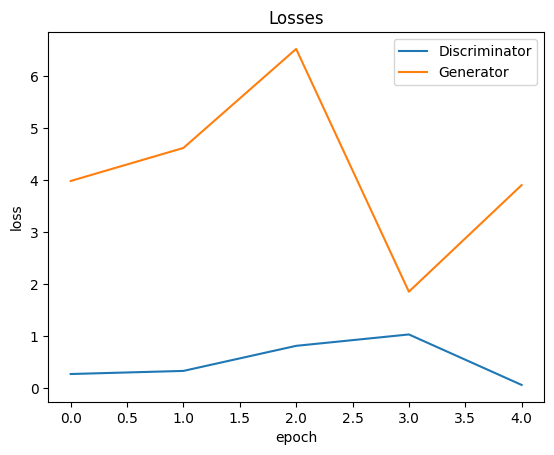

In [17]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [18]:
history = fit(epochs=15, lr=0.0001)

  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [1/15], loss_g: 4.1657, loss_d: 0.2233, real_score: 0.9191, fake_score: 0.1195
Saving generated-images-0001.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [2/15], loss_g: 3.8751, loss_d: 0.1894, real_score: 0.9197, fake_score: 0.0933
Saving generated-images-0002.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [3/15], loss_g: 4.0623, loss_d: 0.2296, real_score: 0.9135, fake_score: 0.1132
Saving generated-images-0003.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [4/15], loss_g: 4.4980, loss_d: 0.1065, real_score: 0.9242, fake_score: 0.0255
Saving generated-images-0004.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [5/15], loss_g: 2.6456, loss_d: 0.3610, real_score: 0.7363, fake_score: 0.0191
Saving generated-images-0005.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [6/15], loss_g: 2.8861, loss_d: 0.5166, real_score: 0.6902, fake_score: 0.0352
Saving generated-images-0006.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [7/15], loss_g: 7.7559, loss_d: 0.2030, real_score: 0.8203, fake_score: 0.0022
Saving generated-images-0007.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [8/15], loss_g: 4.0824, loss_d: 0.1469, real_score: 0.9198, fake_score: 0.0570
Saving generated-images-0008.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [9/15], loss_g: 5.5488, loss_d: 0.1998, real_score: 0.9820, fake_score: 0.1537
Saving generated-images-0009.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [10/15], loss_g: 4.8505, loss_d: 0.0972, real_score: 0.9797, fake_score: 0.0691
Saving generated-images-0010.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [11/15], loss_g: 2.4737, loss_d: 0.2475, real_score: 0.8494, fake_score: 0.0783
Saving generated-images-0011.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [12/15], loss_g: 7.6224, loss_d: 0.1298, real_score: 0.8846, fake_score: 0.0016
Saving generated-images-0012.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [13/15], loss_g: 0.5878, loss_d: 0.4441, real_score: 0.7237, fake_score: 0.0202
Saving generated-images-0013.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [14/15], loss_g: 5.8254, loss_d: 0.1642, real_score: 0.9862, fake_score: 0.1294
Saving generated-images-0014.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [15/15], loss_g: 4.1974, loss_d: 0.3216, real_score: 0.7992, fake_score: 0.0044
Saving generated-images-0015.png


In [19]:
losses_g, losses_d, real_scores, fake_scores = history

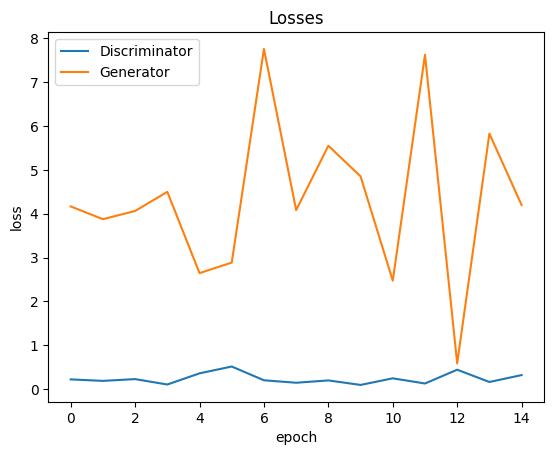

In [20]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');